Shamelessly using model from **`Finlytics Hub`** :
* https://medium.com/towards-data-science/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, classification_report
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('data/application_train.csv')

In [3]:
df.shape

(307511, 122)

In [4]:
pd.options.display.max_columns = None
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
df['SK_ID_CURR'].duplicated().any()
# to check if every row is independent

False

In [6]:
df.drop('SK_ID_CURR', axis = 1, inplace=True)

Text(0.5, 0, '0 = good, 1 = default')

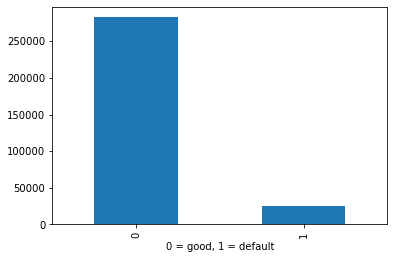

In [7]:
df['TARGET'].value_counts().plot(kind = 'bar').set_xlabel('0 = good, 1 = default')

In [8]:
# Change target 0 = bad, 1 = good because in scorecard : higher -> better
df['TARGET'] = df['TARGET'].apply(lambda x: 1 if x == 0 else 0)

In [9]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = df.drop('TARGET', axis = 1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Feature Selection

We do this first, for the sake of simplicty.

In [10]:
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [11]:
print(list(X_train_num.columns))

['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAR

In [12]:
print(list(X_train_cat.columns))

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


Let's do it, one at a time.

## Categorical

In [13]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
# chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result.merge(X_train_cat.describe().T.reset_index(), left_on ='Feature', right_on = 'index').sort_values(by = ['p-value', 'unique'])

,Feature,p-value,index,count,unique,top,freq
0,NAME_CONTRACT_TYPE,0.000000,NAME_CONTRACT_TYPE,246008,2,Cash loans,222521
2,FLAG_OWN_CAR,0.000000,FLAG_OWN_CAR,246008,2,N,162453
1,CODE_GENDER,0.000000,CODE_GENDER,246008,3,F,162038
6,NAME_EDUCATION_TYPE,0.000000,NAME_EDUCATION_TYPE,246008,5,Secondary / secondary special,174765
7,NAME_FAMILY_STATUS,0.000000,NAME_FAMILY_STATUS,246008,6,Married,157064
8,NAME_HOUSING_TYPE,0.000000,NAME_HOUSING_TYPE,246008,6,House / apartment,218329
14,WALLSMATERIAL_MODE,0.000000,WALLSMATERIAL_MODE,120988,7,Panel,52839
5,NAME_INCOME_TYPE,0.000000,NAME_INCOME_TYPE,246008,8,Working,127003
9,OCCUPATION_TYPE,0.000000,OCCUPATION_TYPE,168853,18,Laborers,44074
11,ORGANIZATION_TYPE,0.000000,ORGANIZATION_TYPE,246008,58,Business Entity Type 3,54447


How do we pick categorical data?
* Low cardinality (unique)
* No null value
* lowest p-value

Tips: Don't have too much features on Logistic Regression

In [14]:
X_train['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'Municipal apartment', 'Rented apartment',
       'With parents', 'Office apartment', 'Co-op apartment'],
      dtype=object)

In [15]:
X_train['NAME_INCOME_TYPE'].unique()

array(['Pensioner', 'Commercial associate', 'Working', 'State servant',
       'Student', 'Unemployed', 'Maternity leave', 'Businessman'],
      dtype=object)

In [16]:
selected_cat_cols = ['FLAG_OWN_CAR', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE']

In [17]:
X_train[selected_cat_cols].head()

,FLAG_OWN_CAR,CODE_GENDER,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_INCOME_TYPE
246542,N,F,Secondary / secondary special,Married,Pensioner
166649,Y,F,Higher education,Married,Commercial associate
213816,Y,M,Secondary / secondary special,Separated,Commercial associate
255236,N,F,Higher education,Single / not married,Working
254621,Y,M,Secondary / secondary special,Single / not married,Commercial associate


NAME_CONTRACT_TYPE, NAME_HOUSING_TYPE aren't selected because they have 1 variable with too much frequency.

## Numerical

In [18]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num.fillna(X_train_num.median()), y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.merge(X_train_num.describe().T.reset_index(), left_on = 'Numerical_Feature', right_on = 'index').sort_values(['F-Score', 'count'], ascending=False).head(50)

,Numerical_Feature,F-Score,p values,index,count,mean,std,min,25%,50%,75%,max
28,EXT_SOURCE_2,6518.576280,0.0,EXT_SOURCE_2,245469.0,0.514259,0.191124,8.173617e-08,0.392072,0.565832,0.663627,8.549997e-01
29,EXT_SOURCE_3,5995.804669,0.0,EXT_SOURCE_3,197141.0,0.510714,0.194946,5.272652e-04,0.370650,0.535276,0.669057,8.960095e-01
27,EXT_SOURCE_1,2496.684508,0.0,EXT_SOURCE_1,107420.0,0.501780,0.210815,1.456813e-02,0.334022,0.505721,0.674091,9.516240e-01
6,DAYS_BIRTH,1522.372017,0.0,DAYS_BIRTH,246008.0,-16029.807331,4359.823101,-2.522900e+04,-19673.000000,-15739.000000,-12410.000000,-7.489000e+03
19,REGION_RATING_CLIENT_W_CITY,913.906244,0.0,REGION_RATING_CLIENT_W_CITY,246008.0,2.031239,0.502947,1.000000e+00,2.000000,2.000000,2.000000,3.000000e+00
18,REGION_RATING_CLIENT,860.350408,0.0,REGION_RATING_CLIENT,246008.0,2.052340,0.509193,1.000000e+00,2.000000,2.000000,2.000000,3.000000e+00
77,DAYS_LAST_PHONE_CHANGE,767.742734,0.0,DAYS_LAST_PHONE_CHANGE,246007.0,-963.105456,827.031758,-4.292000e+03,-1570.000000,-757.000000,-274.000000,0.000000e+00
9,DAYS_ID_PUBLISH,674.965486,0.0,DAYS_ID_PUBLISH,246008.0,-2993.689616,1509.386678,-7.197000e+03,-4298.000000,-3256.000000,-1716.000000,0.000000e+00
25,REG_CITY_NOT_WORK_CITY,630.086032,0.0,REG_CITY_NOT_WORK_CITY,246008.0,0.230395,0.421086,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
12,FLAG_EMP_PHONE,512.340368,0.0,FLAG_EMP_PHONE,246008.0,0.820290,0.383946,0.000000e+00,1.000000,1.000000,1.000000,1.000000e+00


EXT_SOURCE -> External source's score.

In [19]:
temp_num_cols = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_LAST_PHONE_CHANGE', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 
                 'REG_CITY_NOT_LIVE_CITY', 'DAYS_EMPLOYED', 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE', 'LIVE_CITY_NOT_WORK_CITY', 'AMT_CREDIT', 
                 'FLAG_DOCUMENT_6', 'CNT_CHILDREN']

In general, an absolute correlation coefficient of >0.7 among two or more predictors indicates the presence of multicollinearity

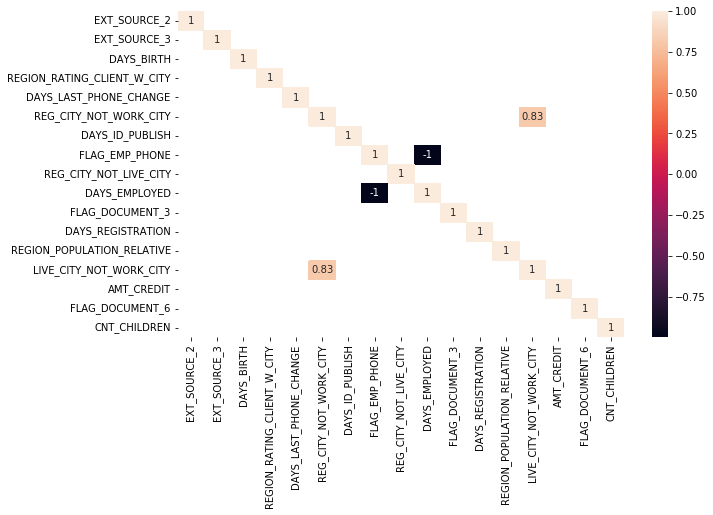

In [20]:
var_corr = X_train[temp_num_cols].corr()
fig = plt.figure(figsize = (10,6))
sns.heatmap(var_corr, annot=True, mask = (abs(var_corr) <= 0.7))

In [21]:
selected_num_cols = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_LIVE_CITY', 'DAYS_EMPLOYED', 
                 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE', 'LIVE_CITY_NOT_WORK_CITY', 'AMT_CREDIT', 'FLAG_DOCUMENT_6', 'CNT_CHILDREN']

In [22]:
X_train[selected_num_cols].head()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_LIVE_CITY,DAYS_EMPLOYED,FLAG_DOCUMENT_3,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,AMT_CREDIT,FLAG_DOCUMENT_6,CNT_CHILDREN
246542,0.391577,0.413597,-19980,2,-1591.0,-3270,0,365243,1,-7521.0,0.011703,0,127350.0,0,0
166649,0.707909,0.633032,-16598,1,-856.0,-129,0,-298,0,-7925.0,0.072508,0,1227901.5,0,0
213816,0.667288,0.466864,-21515,2,-650.0,-4028,0,-2174,1,-629.0,0.019101,0,1215000.0,0,0
255236,0.708474,NaN,-13342,1,-3.0,-916,0,-5943,1,-7252.0,0.072508,0,450000.0,0,0
254621,0.595523,0.448962,-15974,3,-853.0,-568,0,-1130,1,-217.0,0.003122,0,545040.0,0,0


For this numerical data, we will impute / clean with median, for simplicity.

In [23]:
selected_cols = selected_cat_cols + selected_num_cols

In [24]:
X_train = X_train[selected_cols]
X_test = X_test[selected_cols]

In [25]:
from sklearn.impute import SimpleImputer

numimputer = SimpleImputer(strategy = 'median')

In [26]:
X_train[selected_num_cols] = numimputer.fit_transform(X_train[selected_num_cols])
X_test[selected_num_cols] = numimputer.transform(X_test[selected_num_cols])

In [27]:
def dummy_creation(df, cols):
    df_dummies = pd.get_dummies(df[cols], prefix_sep = ':')
    df = pd.concat([df, df_dummies], axis = 1)
    return df

In [28]:
X_train = dummy_creation(X_train, selected_cat_cols)
X_test = dummy_creation(X_test, selected_cat_cols)

In [29]:
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

# WoE Binning / Feature Engineering

In [30]:
pd.DataFrame({'Information Value': ['< 0.02', '0.02 - 0.1', '0.1 - 0.3', '0.3 - 0.5', '> 0.5'],
'Variable Predictiveness' : ['Not useful for prediction','Weak predictive power','Medium Predictive Power','Strong predictive power','suspicious predictive power']})

,Information Value,Variable Predictiveness
0,< 0.02,Not useful for prediction
1,0.02 - 0.1,Weak predictive power
2,0.1 - 0.3,Medium Predictive Power
3,0.3 - 0.5,Strong predictive power
4,> 0.5,suspicious predictive power


In [31]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

## Categorical

In [32]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_discrete(df, cat_variable_name, y_df):
    df = pd.concat([df[cat_variable_name], y_df], axis = 1)
    df = df.groupby(cat_variable_name, as_index=False).agg({df.columns[1]: ['count', 'sum']})
    df.columns = [cat_variable_name, 'n_obs', 'n_bad']
    df['n_good'] = df['n_obs'] - df['n_bad']
    
    # WOE
    df['total_dist'] = df['n_obs'] / df['n_obs'].sum()
    df['bad_dist'] = df['n_bad'] / df['n_bad'].sum()
    df['good_dist'] = df['n_good'] / df['n_good'].sum()
    df['WoE'] = np.log(df['good_dist'] / df['bad_dist'])
    df = df.sort_values(['WoE'])
    
    # IV 
    df['IV'] = (df['good_dist'] - df['bad_dist']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [33]:
# We set the default style of the graphs to the seaborn style. 
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    plt.figure(figsize=(18, 6))
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    sns.lineplot(x = x, y = y, marker = 'o', linestyle = ':', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)
    plt.show()

In [34]:
selected_cat_cols

['FLAG_OWN_CAR',
 'CODE_GENDER',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_INCOME_TYPE']

**FLAG_OWN_CAR**

In [35]:
df_temp = woe_discrete(X_train_prepr, 'FLAG_OWN_CAR', y_train_prepr)
df_temp

,FLAG_OWN_CAR,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
1,Y,83555,77536,6019,0.339643,0.342855,0.303072,-0.123339,0.007245
0,N,162453,148612,13841,0.660357,0.657145,0.696928,0.058778,0.007245


IV < 0.02 = Not useful for prediction

**CODE_GENDER**

In [36]:
df_temp = woe_discrete(X_train_prepr, 'CODE_GENDER', y_train_prepr)
df_temp

C:\Users\Asif\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CODE_GENDER,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
2,XNA,2,2,0,0.000008,0.000009,0.000000,-inf,inf
0,F,162038,150670,11368,0.658670,0.666245,0.572407,-0.151808,inf
1,M,83968,75476,8492,0.341322,0.333746,0.427593,0.247792,inf


Problem: XNA

Simple `temporary` solution until we have much more data on XNA -> change XNA to female....

In [37]:
X_train_prepr['CODE_GENDER'] = X_train_prepr['CODE_GENDER'].apply(lambda x: 'F' if x == 'XNA' else x)

In [38]:
df_temp = woe_discrete(X_train_prepr, 'CODE_GENDER', y_train_prepr)
df_temp

,CODE_GENDER,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,F,162040,150672,11368,0.658678,0.666254,0.572407,-0.151821,0.037502
1,M,83968,75476,8492,0.341322,0.333746,0.427593,0.247792,0.037502


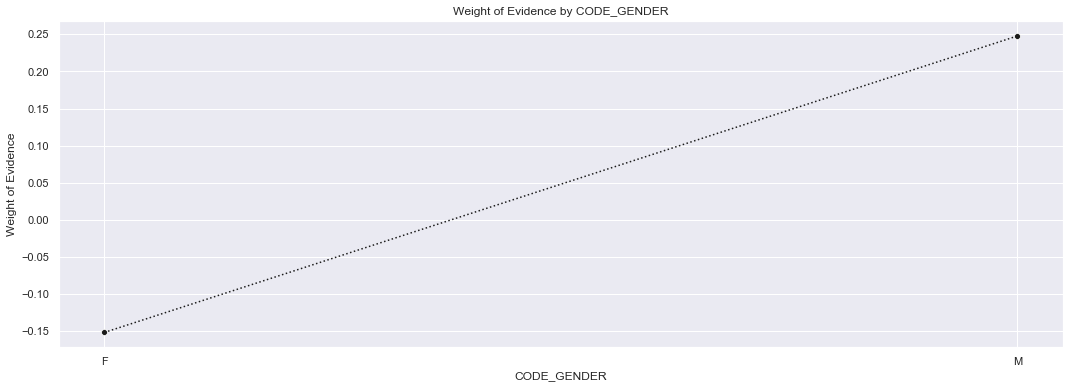

In [39]:
plot_by_woe(df_temp)

**NAME_EDUCATION_TYPE**

In [40]:
df_temp = woe_discrete(X_train_prepr, 'NAME_EDUCATION_TYPE', y_train_prepr)
df_temp

,NAME_EDUCATION_TYPE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,Academic degree,124,121,3,0.000504,0.000535,0.000151,-1.264696,0.048773
1,Higher education,59829,56594,3235,0.243199,0.250252,0.162890,-0.429392,0.048773
2,Incomplete higher,8260,7547,713,0.033576,0.033372,0.035901,0.073058,0.048773
4,Secondary / secondary special,174765,159199,15566,0.710404,0.703959,0.783787,0.107416,0.048773
3,Lower secondary,3030,2687,343,0.012317,0.011882,0.017271,0.374032,0.048773


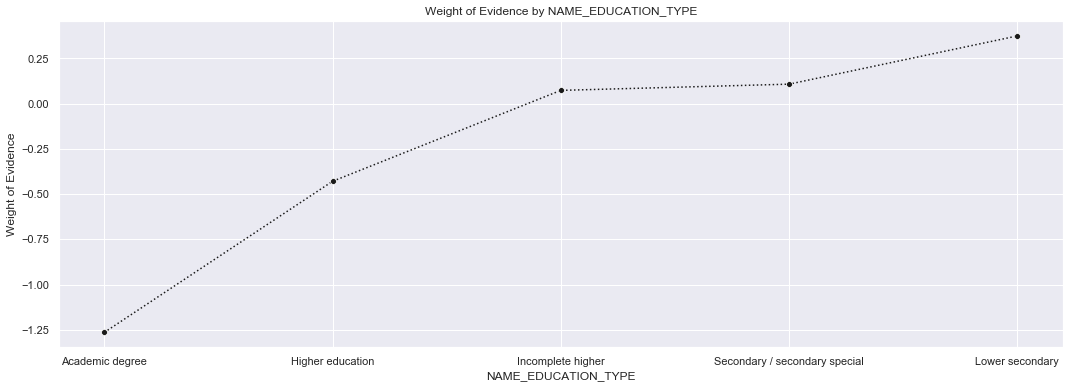

In [41]:
plot_by_woe(df_temp)

**NAME_FAMILY_STATUS**

In [42]:
df_temp = woe_discrete(X_train_prepr, 'NAME_FAMILY_STATUS', y_train_prepr)
df_temp

C:\Users\Asif\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,NAME_FAMILY_STATUS,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
4,Unknown,1,1,0,0.000004,0.000004,0.000000,-inf,inf
5,Widow,12846,12102,744,0.052218,0.053514,0.037462,-0.356603,inf
1,Married,157064,145177,11887,0.638451,0.641956,0.598540,-0.070026,inf
2,Separated,15853,14568,1285,0.064441,0.064418,0.064703,0.004413,inf
3,Single / not married,36380,32817,3563,0.147881,0.145113,0.179406,0.212138,inf
0,Civil marriage,23864,21483,2381,0.097005,0.094995,0.119889,0.232741,inf


Problem: Unknown

Simple `temporary` solution until we have much more data on Unknown -> change Unknown to single....

In [43]:
X_train_prepr['NAME_FAMILY_STATUS'] = X_train_prepr['NAME_FAMILY_STATUS'].apply(lambda x: 'Single / not married' if x == 'Unknown' else x)

In [44]:
df_temp = woe_discrete(X_train_prepr, 'NAME_FAMILY_STATUS', y_train_prepr)
df_temp

,NAME_FAMILY_STATUS,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
4,Widow,12846,12102,744,0.052218,0.053514,0.037462,-0.356603,0.021832
1,Married,157064,145177,11887,0.638451,0.641956,0.598540,-0.070026,0.021832
2,Separated,15853,14568,1285,0.064441,0.064418,0.064703,0.004413,0.021832
3,Single / not married,36381,32818,3563,0.147885,0.145117,0.179406,0.212108,0.021832
0,Civil marriage,23864,21483,2381,0.097005,0.094995,0.119889,0.232741,0.021832


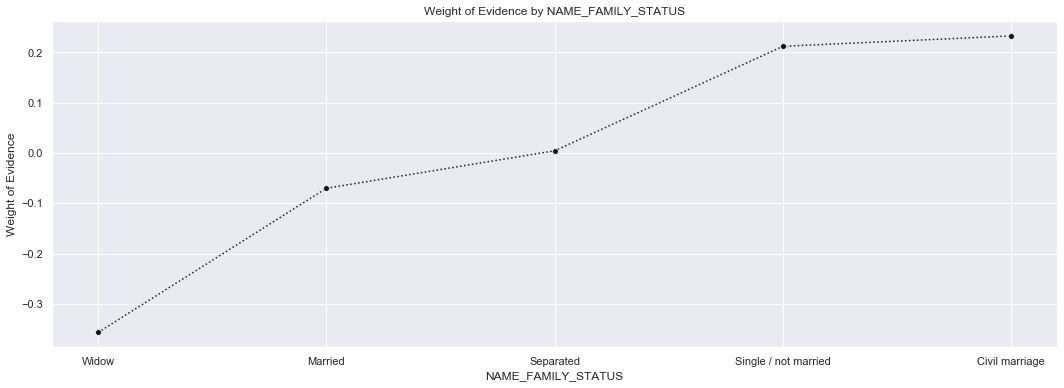

In [45]:
plot_by_woe(df_temp)

**NAME_INCOME_TYPE**

In [46]:
df_temp = woe_discrete(X_train_prepr, 'NAME_INCOME_TYPE', y_train_prepr)
df_temp

C:\Users\Asif\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,NAME_INCOME_TYPE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,Businessman,9,9,0,0.000037,0.000040,0.000000,-inf,inf
5,Student,12,12,0,0.000049,0.000053,0.000000,-inf,inf
3,Pensioner,44190,41800,2390,0.179628,0.184835,0.120342,-0.429121,inf
4,State servant,17505,16518,987,0.071156,0.073041,0.049698,-0.385054,inf
1,Commercial associate,57266,52972,4294,0.232781,0.234236,0.216213,-0.080063,inf
7,Working,127003,114821,12182,0.516256,0.507725,0.613394,0.189067,inf
6,Unemployed,18,13,5,0.000073,0.000057,0.000252,1.476971,inf
2,Maternity leave,5,3,2,0.000020,0.000013,0.000101,2.027017,inf


Problem: Businessman, Maternity leave, Student

Simple `temporary` solution until we have much more data on Businessman, Maternity leave, Student:
* Change Businessman to Commercial associate
* Change maternity leave to Pensioner
* Change student to Unemployed

In [47]:
def nameincometype(ityp):
    if ityp == 'Businessman':
        return 'Commercial associate'
    elif ityp == 'Maternity leave':
        return 'Pensioner'
    elif ityp == 'Student':
        return 'Unemployed'
    else: return ityp

In [48]:
X_train_prepr['NAME_INCOME_TYPE'] = X_train_prepr['NAME_INCOME_TYPE'].apply(nameincometype)

In [49]:
df_temp = woe_discrete(X_train_prepr, 'NAME_INCOME_TYPE', y_train_prepr)
df_temp

,NAME_INCOME_TYPE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
1,Pensioner,44195,41803,2392,0.179649,0.184848,0.120443,-0.428356,0.05812
2,State servant,17505,16518,987,0.071156,0.073041,0.049698,-0.385054,0.05812
0,Commercial associate,57275,52981,4294,0.232818,0.234276,0.216213,-0.080233,0.05812
4,Working,127003,114821,12182,0.516256,0.507725,0.613394,0.189067,0.05812
3,Unemployed,30,25,5,0.000122,0.000111,0.000252,0.823044,0.05812


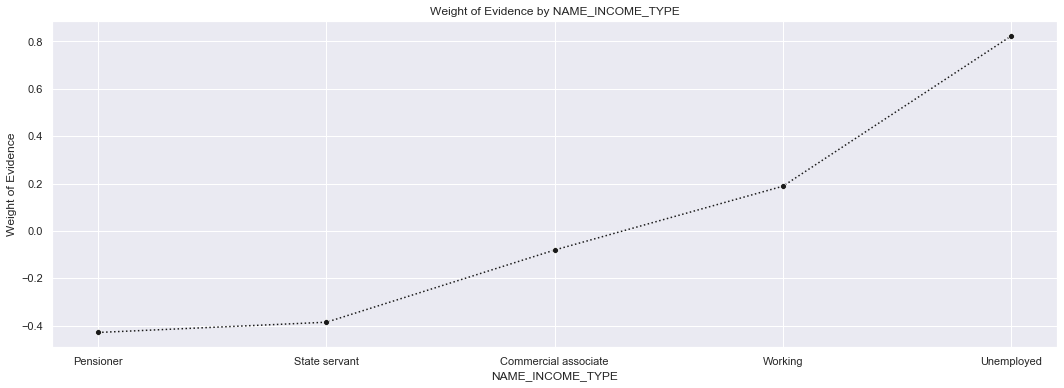

In [50]:
plot_by_woe(df_temp)

## Numerical

In [51]:
X_train_prepr[selected_num_cols].nunique().sort_values()

REG_CITY_NOT_LIVE_CITY              2
FLAG_DOCUMENT_3                     2
LIVE_CITY_NOT_WORK_CITY             2
FLAG_DOCUMENT_6                     2
REGION_RATING_CLIENT_W_CITY         3
CNT_CHILDREN                       14
REGION_POPULATION_RELATIVE         81
EXT_SOURCE_3                      806
DAYS_LAST_PHONE_CHANGE           3737
AMT_CREDIT                       5289
DAYS_ID_PUBLISH                  6144
DAYS_EMPLOYED                   12057
DAYS_REGISTRATION               15417
DAYS_BIRTH                      17412
EXT_SOURCE_2                   108834
dtype: int64

In [52]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the 2 commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_ordered_continuous(df, cat_variable_name, y_df):
    df = pd.concat([df[cat_variable_name], y_df], axis = 1)
    df = df.groupby(cat_variable_name, as_index=False).agg({df.columns[1]: ['count', 'sum']})
    df.columns = [cat_variable_name, 'n_obs', 'n_bad']
    df['n_good'] = df['n_obs'] - df['n_bad']
    
    # WOE
    df['total_dist'] = df['n_obs'] / df['n_obs'].sum()
    df['bad_dist'] = df['n_bad'] / df['n_bad'].sum()
    df['good_dist'] = df['n_good'] / df['n_good'].sum()
    df['WoE'] = np.log(df['good_dist'] / df['bad_dist'])
    #df = df.sort_values(['WoE'])
    
    # IV 
    df['IV'] = (df['good_dist'] - df['bad_dist']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

**REG_CITY_NOT_LIVE_CITY**

In [53]:
df_temp = woe_ordered_continuous(X_train_prepr, 'REG_CITY_NOT_LIVE_CITY', y_train_prepr)
df_temp

,REG_CITY_NOT_LIVE_CITY,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,226815,209306,17509,0.921982,0.925527,0.881621,-0.048600,0.022482
1,1.0,19193,16842,2351,0.078018,0.074473,0.118379,0.463447,0.022482


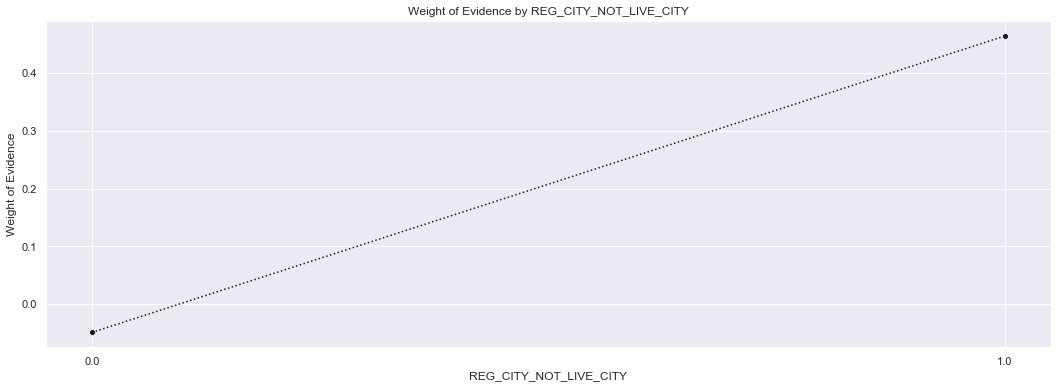

In [54]:
plot_by_woe(df_temp)

**FLAG_DOCUMENT_3**

In [55]:
df_temp = woe_ordered_continuous(X_train_prepr, 'FLAG_DOCUMENT_3', y_train_prepr)
df_temp

,FLAG_DOCUMENT_3,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,71435,67034,4401,0.290377,0.296417,0.221601,-0.290886,0.029323
1,1.0,174573,159114,15459,0.709623,0.703583,0.778399,0.101052,0.029323


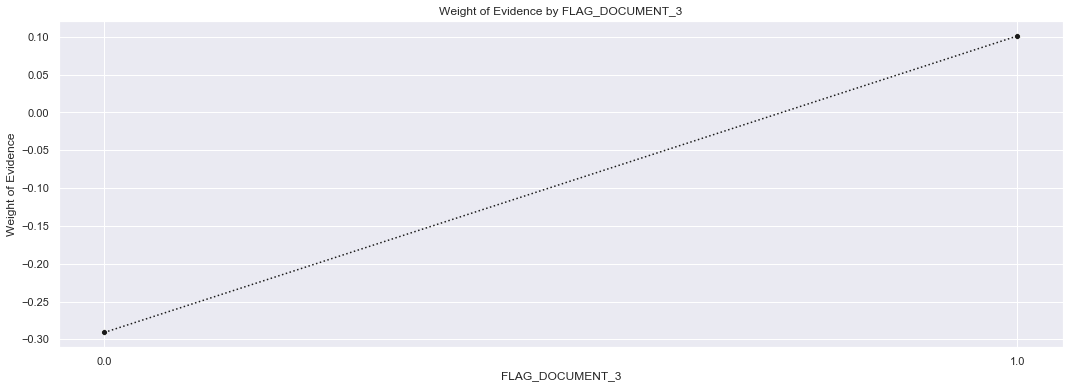

In [56]:
plot_by_woe(df_temp)

**LIVE_CITY_NOT_WORK_CITY**

In [57]:
df_temp = woe_ordered_continuous(X_train_prepr, 'LIVE_CITY_NOT_WORK_CITY', y_train_prepr)
df_temp

,LIVE_CITY_NOT_WORK_CITY,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,201813,186319,15494,0.820351,0.823881,0.780161,-0.054525,0.012078
1,1.0,44195,39829,4366,0.179649,0.176119,0.219839,0.221734,0.012078


IV < 0.02

**FLAG_DOCUMENT_6**

In [58]:
df_temp = woe_ordered_continuous(X_train_prepr, 'FLAG_DOCUMENT_6', y_train_prepr)
df_temp

,FLAG_DOCUMENT_6,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,224339,205678,18661,0.911917,0.909484,0.939627,0.032606,0.013191
1,1.0,21669,20470,1199,0.088083,0.090516,0.060373,-0.404991,0.013191


IV < 0.02

**REGION_RATING_CLIENT_W_CITY**

In [59]:
df_temp = woe_ordered_continuous(X_train_prepr, 'REGION_RATING_CLIENT_W_CITY', y_train_prepr)
df_temp

,REGION_RATING_CLIENT_W_CITY,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,1.0,27392,26071,1321,0.111346,0.115283,0.066516,-0.549953,0.051268
1,2.0,183539,168992,14547,0.746069,0.747263,0.732477,-0.019985,0.051268
2,3.0,35077,31085,3992,0.142585,0.137454,0.201007,0.380049,0.051268


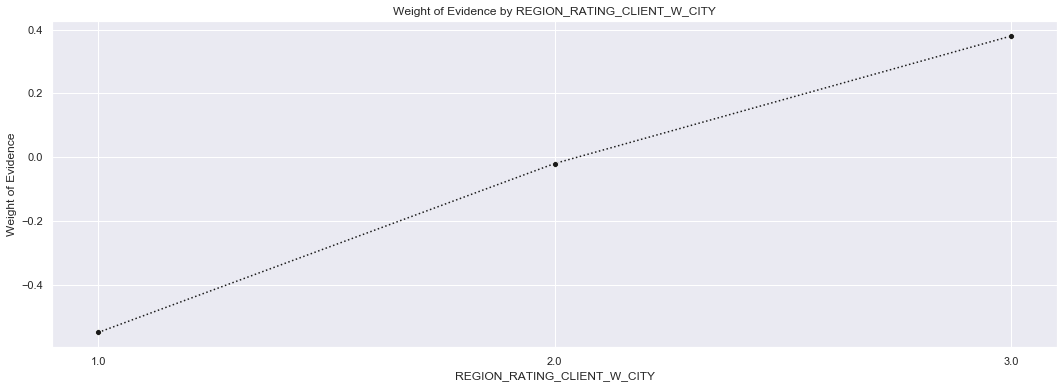

In [60]:
plot_by_woe(df_temp)

**CNT_CHILDREN**

In [61]:
df_temp = woe_ordered_continuous(X_train_prepr, 'CNT_CHILDREN', y_train_prepr)
df_temp

C:\Users\Asif\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CNT_CHILDREN,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,172178,158937,13241,0.699888,0.702801,0.666717,-0.052708,inf
1,1.0,49013,44591,4422,0.199233,0.197176,0.222659,0.121542,inf
2,2.0,21440,19567,1873,0.087152,0.086523,0.094310,0.086179,inf
3,3.0,2940,2673,267,0.011951,0.011820,0.013444,0.128774,inf
4,4.0,327,284,43,0.001329,0.001256,0.002165,0.544708,inf
5,5.0,75,69,6,0.000305,0.000305,0.000302,-0.009865,inf
6,6.0,18,12,6,0.000073,0.000053,0.000302,1.739335,inf
7,7.0,6,6,0,0.000024,0.000027,0.000000,-inf,inf
8,8.0,2,2,0,0.000008,0.000009,0.000000,-inf,inf
9,9.0,1,0,1,0.000004,0.000000,0.000050,inf,inf


Problem: children count: 7,8,10,12,14,19

I think we should remove children > 6...

In [62]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['CNT_CHILDREN'] <= 6].copy()

df_temp = woe_ordered_continuous(X_train_prepr_temp, 'CNT_CHILDREN', y_train_prepr)
df_temp

,CNT_CHILDREN,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,172178,158937,13241,0.699936,0.702847,0.666784,-0.052673,0.006808
1,1.0,49013,44591,4422,0.199247,0.197189,0.222681,0.121576,0.006808
2,2.0,21440,19567,1873,0.087158,0.086529,0.094320,0.086213,0.006808
3,3.0,2940,2673,267,0.011952,0.011820,0.013445,0.128808,0.006808
4,4.0,327,284,43,0.001329,0.001256,0.002165,0.544742,0.006808
5,5.0,75,69,6,0.000305,0.000305,0.000302,-0.009831,0.006808
6,6.0,18,12,6,0.000073,0.000053,0.000302,1.739369,0.006808


Very low IV though.

**REGION_POPULATION_RELATIVE**

In [63]:
# fine-classing
X_train_prepr['REGION_POPULATION_RELATIVE_factor'] = pd.cut(X_train_prepr['REGION_POPULATION_RELATIVE'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'REGION_POPULATION_RELATIVE_factor', y_train_prepr)
df_temp

,REGION_POPULATION_RELATIVE_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(0.000218, 0.0147]",90449,82858,7591,0.367667,0.366388,0.382226,0.042317,0.026641
1,"(0.0147, 0.0292]",100843,92053,8790,0.409918,0.407048,0.442598,0.083732,0.026641
2,"(0.0292, 0.0436]",37197,34520,2677,0.151202,0.152643,0.134794,-0.124360,0.026641
3,"(0.0436, 0.0581]",10829,10299,530,0.044019,0.045541,0.026687,-0.534443,0.026641
4,"(0.0581, 0.0725]",6690,6418,272,0.027194,0.028380,0.013696,-0.728578,0.026641


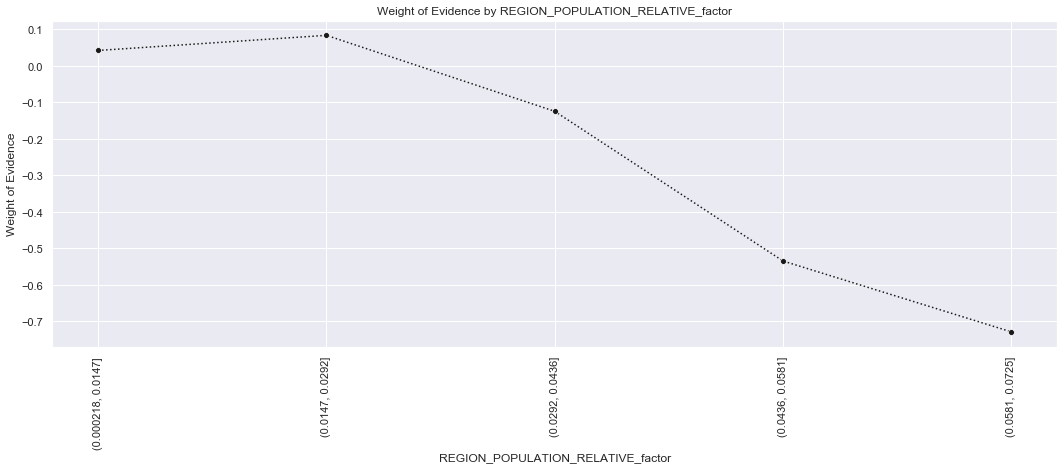

In [64]:
plot_by_woe(df_temp,90)

**DAYS_LAST_PHONE_CHANGE**

In [65]:
# Very rough binning for days -> to year
def toyear(series):
    return -np.floor((series/365))

In [66]:
# fine-classing
X_train_prepr['YEAR_LAST_PHONE_CHANGE'] = toyear(X_train_prepr['DAYS_LAST_PHONE_CHANGE'])
X_train_prepr['YEAR_LAST_PHONE_CHANGE'] = pd.cut(X_train_prepr['YEAR_LAST_PHONE_CHANGE'], 6)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_LAST_PHONE_CHANGE', y_train_prepr)
df_temp

,YEAR_LAST_PHONE_CHANGE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.012, 2.0]",120240,108831,11409,0.488765,0.481238,0.574471,0.177088,0.046062
1,"(2.0, 4.0]",54154,49975,4179,0.220131,0.220984,0.210423,-0.048969,0.046062
2,"(4.0, 6.0]",48138,45116,3022,0.195677,0.199498,0.152165,-0.270836,0.046062
3,"(6.0, 8.0]",18782,17747,1035,0.076347,0.078475,0.052115,-0.409333,0.046062
4,"(8.0, 10.0]",4515,4308,207,0.018353,0.019049,0.010423,-0.603028,0.046062
5,"(10.0, 12.0]",179,171,8,0.000728,0.000756,0.000403,-0.629740,0.046062


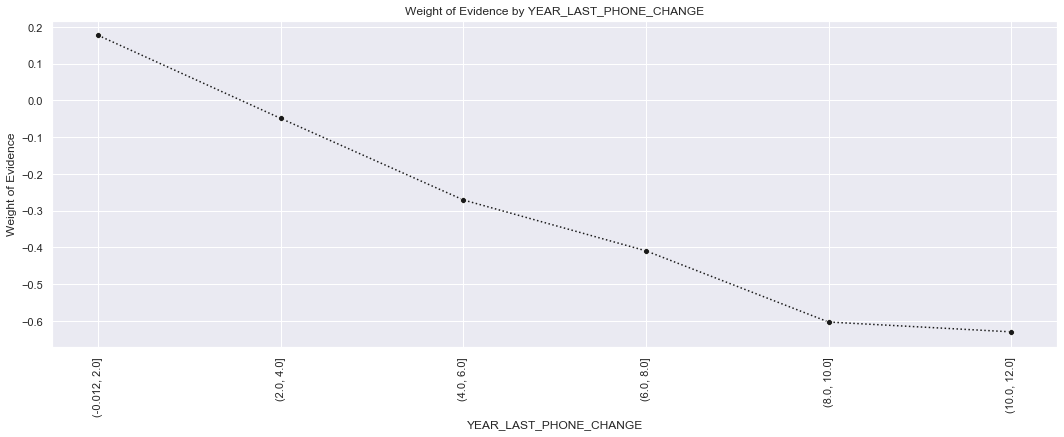

In [67]:
plot_by_woe(df_temp,90)

**AMT_CREDIT**

In [68]:
# fine-classing
X_train_prepr['AMT_CREDIT_factor'] = pd.cut(X_train_prepr['AMT_CREDIT'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'AMT_CREDIT_factor', y_train_prepr)
df_temp

,AMT_CREDIT_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(40995.0, 846000.0]",190293,173858,16435,0.773524,0.768780,0.827543,0.073656,0.024318
1,"(846000.0, 1647000.0]",50714,47498,3216,0.206148,0.210031,0.161934,-0.260067,0.024318
2,"(1647000.0, 2448000.0]",4666,4470,196,0.018967,0.019766,0.009869,-0.694547,0.024318
3,"(2448000.0, 3249000.0]",317,305,12,0.001289,0.001349,0.000604,-0.802923,0.024318
4,"(3249000.0, 4050000.0]",18,17,1,0.000073,0.000075,0.000050,-0.400731,0.024318


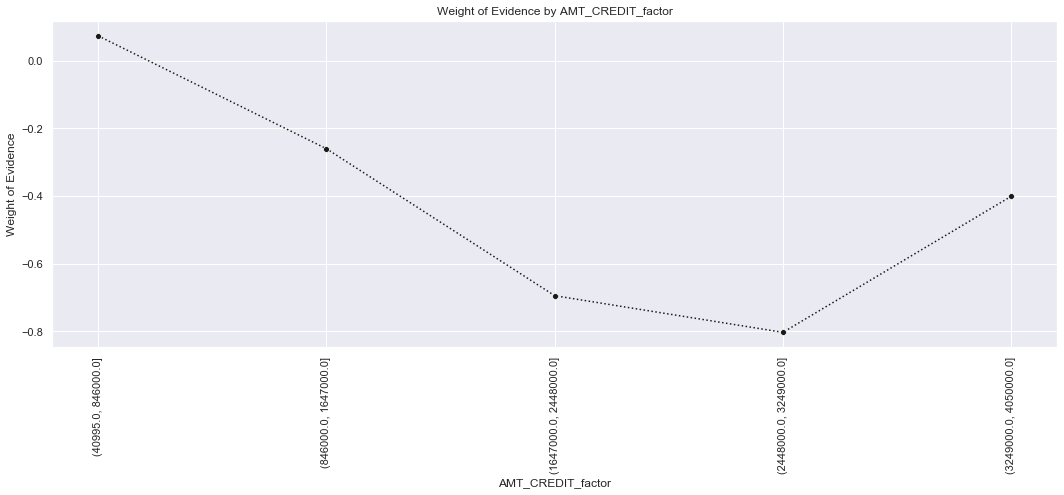

In [69]:
plot_by_woe(df_temp,90)

**DAYS_ID_PUBLISH**

In [70]:
# fine-classing
X_train_prepr['YEAR_ID_PUBLISH'] = toyear(X_train_prepr['DAYS_ID_PUBLISH'])
X_train_prepr['YEAR_ID_PUBLISH'] = pd.cut(X_train_prepr['YEAR_ID_PUBLISH'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_ID_PUBLISH', y_train_prepr)
df_temp

,YEAR_ID_PUBLISH,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.02, 4.0]",52241,46992,5249,0.212355,0.207793,0.264300,0.240542,0.035895
1,"(4.0, 8.0]",57096,52002,5094,0.232090,0.229947,0.256495,0.109263,0.035895
2,"(8.0, 12.0]",82861,76633,6228,0.336822,0.338862,0.313595,-0.077491,0.035895
3,"(12.0, 16.0]",53105,49850,3255,0.215867,0.220431,0.163897,-0.296344,0.035895
4,"(16.0, 20.0]",705,671,34,0.002866,0.002967,0.001712,-0.549927,0.035895


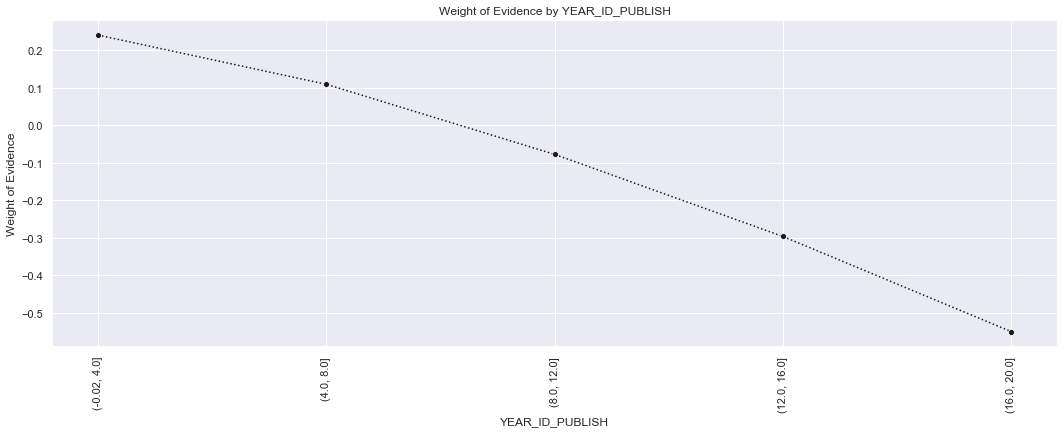

In [71]:
plot_by_woe(df_temp,90)

**DAYS_EMPLOYED**

In [72]:
# fine-classing
X_train_prepr['YEAR_EMPLOYED'] = toyear(X_train_prepr['DAYS_EMPLOYED'])
X_train_prepr['YEAR_EMPLOYED'] = pd.cut(X_train_prepr['YEAR_EMPLOYED'], 2)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_EMPLOYED', y_train_prepr)
df_temp

,YEAR_EMPLOYED,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-1001.049, -475.5]",44200,41805,2395,0.179669,0.184857,0.120594,-0.427151,0.032326
1,"(-475.5, 49.0]",201808,184343,17465,0.820331,0.815143,0.879406,0.075883,0.032326


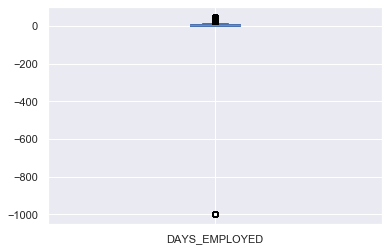

In [73]:
toyear(X_train_prepr['DAYS_EMPLOYED']).plot(kind='box')

I don't understand this feature...... Days employed,some < 0, some > 0 ? With high number of observation too?

Won't be used for now

**DAYS_REGISTRATION**

In [74]:
# fine-classing
X_train_prepr['YEAR_REGISTRATION'] = toyear(X_train_prepr['DAYS_REGISTRATION'])
X_train_prepr['YEAR_REGISTRATION'] = pd.cut(X_train_prepr['YEAR_REGISTRATION'], 4)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_REGISTRATION', y_train_prepr)
df_temp

,YEAR_REGISTRATION,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.068, 17.0]",161752,147509,14243,0.657507,0.652268,0.717170,0.094858,0.021206
1,"(17.0, 34.0]",76957,71726,5231,0.312823,0.317164,0.263394,-0.185769,0.021206
2,"(34.0, 51.0]",7246,6862,384,0.029454,0.030343,0.019335,-0.450630,0.021206
3,"(51.0, 68.0]",53,51,2,0.000215,0.000226,0.000101,-0.806196,0.021206


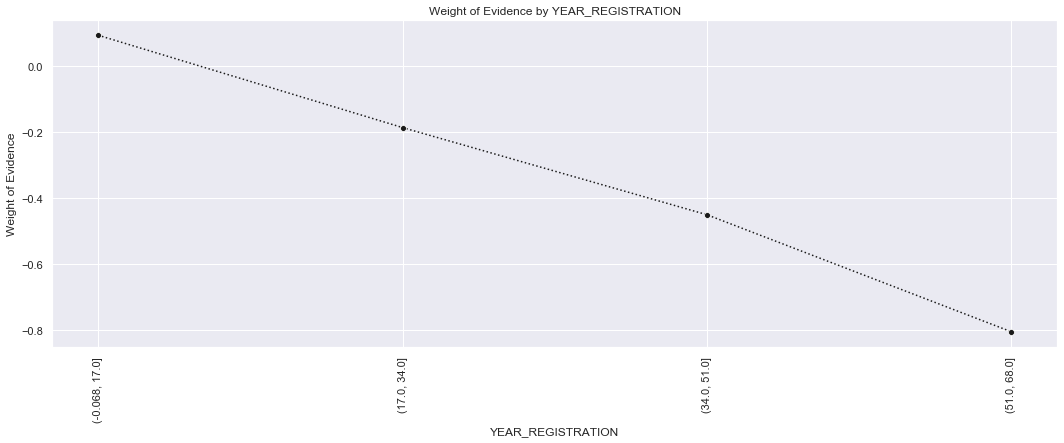

In [75]:
plot_by_woe(df_temp,90)

**DAYS_BIRTH**

In [76]:
# fine-classing
X_train_prepr['YEAR_BIRTH'] = toyear(X_train_prepr['DAYS_BIRTH'])
X_train_prepr['YEAR_BIRTH'] = pd.cut(X_train_prepr['YEAR_BIRTH'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_BIRTH', y_train_prepr)
df_temp

,YEAR_BIRTH,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(20.951, 30.8]",35997,31868,4129,0.146325,0.140917,0.207905,0.388915,0.080286
1,"(30.8, 40.6]",66020,59711,6309,0.268365,0.264035,0.317674,0.184943,0.080286
2,"(40.6, 50.4]",61326,56619,4707,0.249285,0.250363,0.237009,-0.054812,0.080286
3,"(50.4, 60.2]",54357,51027,3330,0.220956,0.225635,0.167674,-0.296901,0.080286
4,"(60.2, 70.0]",28308,26923,1385,0.115069,0.119050,0.069738,-0.534799,0.080286


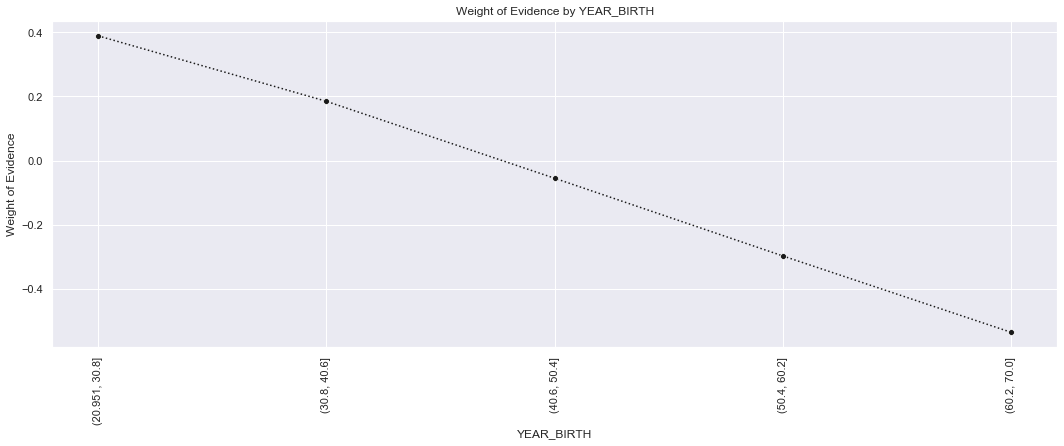

In [77]:
plot_by_woe(df_temp,90)

**EXT_SOURCE_2**

In [78]:
# fine-classing
X_train_prepr['EXT_SOURCE_2_factor'] = pd.cut(X_train_prepr['EXT_SOURCE_2'], 10)

df_temp = woe_ordered_continuous(X_train_prepr, 'EXT_SOURCE_2_factor', y_train_prepr)
df_temp

,EXT_SOURCE_2_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.000855, 0.0855]",7616,5775,1841,0.030958,0.025536,0.092699,1.289253,0.317368
1,"(0.0855, 0.171]",10347,8599,1748,0.042060,0.038024,0.088016,0.839308,0.317368
2,"(0.171, 0.256]",13317,11477,1840,0.054132,0.050750,0.092649,0.601903,0.317368
3,"(0.256, 0.342]",18373,16274,2099,0.074685,0.071962,0.105690,0.384374,0.317368
4,"(0.342, 0.427]",20680,18595,2085,0.084062,0.082225,0.104985,0.244358,0.317368
5,"(0.427, 0.513]",28298,25915,2383,0.115029,0.114593,0.119990,0.046020,0.317368
6,"(0.513, 0.598]",43229,40136,3093,0.175722,0.177477,0.155740,-0.130650,0.317368
7,"(0.598, 0.684]",56324,53224,3100,0.228952,0.235350,0.156093,-0.410625,0.317368
8,"(0.684, 0.769]",42660,41103,1557,0.173409,0.181753,0.078399,-0.840838,0.317368
9,"(0.769, 0.855]",5164,5050,114,0.020991,0.022331,0.005740,-1.358463,0.317368


Feature with strong predictive power, finally. But this will make us dependent to SOURCE 2

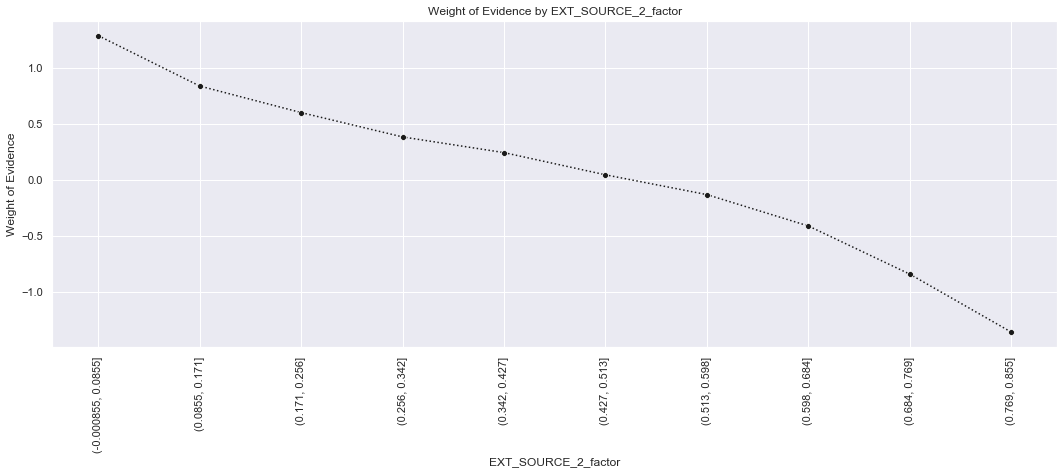

In [79]:
plot_by_woe(df_temp,90)

**EXT_SOURCE_3**

In [80]:
# fine-classing
X_train_prepr['EXT_SOURCE_3_factor'] = pd.cut(X_train_prepr['EXT_SOURCE_3'], 10)

df_temp = woe_ordered_continuous(X_train_prepr, 'EXT_SOURCE_3_factor', y_train_prepr)
df_temp

,EXT_SOURCE_3_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.000368, 0.0901]",3615,2675,940,0.014695,0.011829,0.047331,1.386657,0.320361
1,"(0.0901, 0.18]",9251,7381,1870,0.037604,0.032638,0.094159,1.059511,0.320361
2,"(0.18, 0.269]",13989,11863,2126,0.056864,0.052457,0.107049,0.713300,0.320361
3,"(0.269, 0.359]",19288,17139,2149,0.078404,0.075787,0.108207,0.356128,0.320361
4,"(0.359, 0.448]",24314,22190,2124,0.098834,0.098122,0.106949,0.086141,0.320361
5,"(0.448, 0.538]",77699,71184,6515,0.315839,0.314767,0.328046,0.041321,0.320361
6,"(0.538, 0.627]",32915,31205,1710,0.133796,0.137985,0.086103,-0.471603,0.320361
7,"(0.627, 0.717]",34333,32894,1439,0.139561,0.145453,0.072457,-0.696860,0.320361
8,"(0.717, 0.806]",24437,23638,799,0.099334,0.104524,0.040232,-0.954768,0.320361
9,"(0.806, 0.896]",6167,5979,188,0.025068,0.026438,0.009466,-1.027085,0.320361


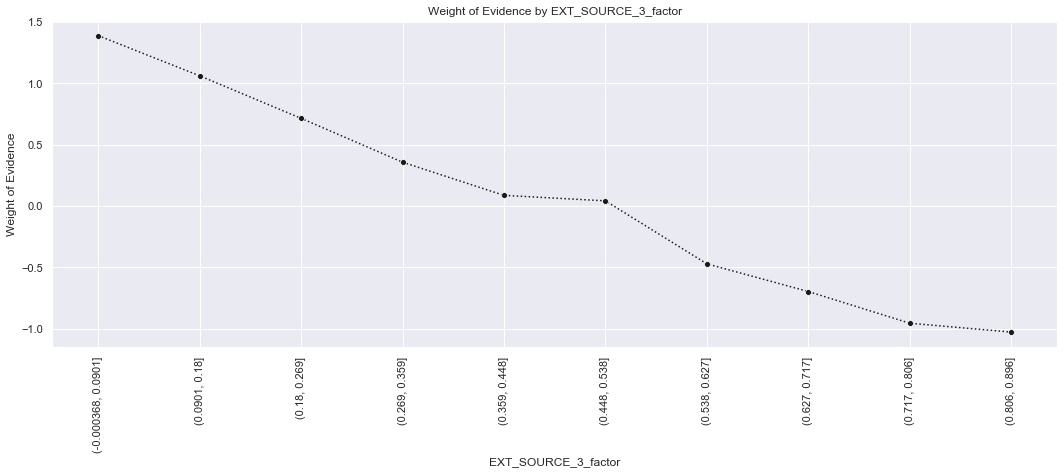

In [81]:
plot_by_woe(df_temp,90)

## Define Custom Class for WoE Binning/Reengineering

In [82]:
# This custom class will create new categorical dummy features based on the cut-off points that we manually identified
# based on the WoE plots and IV above.
# Given the way it is structured, this class also allows a fit_transform method to be implemented on it, thereby allowing 
# us to use it as part of a scikit-learn Pipeline 
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'CODE_GENDER:M'].to_frame()
        X_new['CODE_GENDER:F_XNA'] = sum([X['CODE_GENDER:F'], X['CODE_GENDER:XNA']])

        X_new['NAME_EDUCATION_TYPE:Academic degree'] = X.loc[:,'NAME_EDUCATION_TYPE:Academic degree']
        X_new['NAME_EDUCATION_TYPE:Higher education'] = X.loc[:,'NAME_EDUCATION_TYPE:Higher education']
        X_new['NAME_EDUCATION_TYPE:Incomplete higher'] = X.loc[:,'NAME_EDUCATION_TYPE:Incomplete higher']
        X_new['NAME_EDUCATION_TYPE:Lower secondary'] = X.loc[:,'NAME_EDUCATION_TYPE:Lower secondary']
        X_new['NAME_EDUCATION_TYPE:Secondary / secondary special'] = X.loc[:,'NAME_EDUCATION_TYPE:Secondary / secondary special']

        X_new['NAME_FAMILY_STATUS:Single_Unknown'] = X['NAME_FAMILY_STATUS:Single / not married'] | X['NAME_FAMILY_STATUS:Unknown']
        X_new['NAME_FAMILY_STATUS:Civil marriage'] = X.loc[:,'NAME_FAMILY_STATUS:Civil marriage']
        X_new['NAME_FAMILY_STATUS:Married'] = X.loc[:,'NAME_FAMILY_STATUS:Married']
        X_new['NAME_FAMILY_STATUS:Separated'] = X.loc[:,'NAME_FAMILY_STATUS:Separated']
        X_new['NAME_FAMILY_STATUS:Widow'] = X.loc[:,'NAME_FAMILY_STATUS:Widow']

        X_new['NAME_INCOME_TYPE:Business_comm'] = X['NAME_INCOME_TYPE:Businessman'] | X['NAME_INCOME_TYPE:Commercial associate']
        X_new['NAME_INCOME_TYPE:Pensioner_maternity'] = X['NAME_INCOME_TYPE:Pensioner'] | X['NAME_INCOME_TYPE:Maternity leave']
        X_new['NAME_INCOME_TYPE:student_unemployed'] = X['NAME_INCOME_TYPE:Student'] | X['NAME_INCOME_TYPE:Unemployed']
        X_new['NAME_INCOME_TYPE:State servant'] = X.loc[:,'NAME_INCOME_TYPE:State servant']
        X_new['NAME_INCOME_TYPE:Working'] = X.loc[:,'NAME_INCOME_TYPE:Working']

        # numerical
        X_new['REG_CITY_NOT_LIVE_CITY:0'] = np.where((X['REG_CITY_NOT_LIVE_CITY'] == 0), 1, 0)
        X_new['REG_CITY_NOT_LIVE_CITY:1'] = np.where((X['REG_CITY_NOT_LIVE_CITY'] == 1), 1, 0)

        X_new['FLAG_DOCUMENT_3:0'] = np.where((X['FLAG_DOCUMENT_3'] == 0), 1, 0)
        X_new['FLAG_DOCUMENT_3:1'] = np.where((X['FLAG_DOCUMENT_3'] == 1), 1, 0)

        X_new['REGION_RATING_CLIENT_W_CITY:0'] = np.where((X['REGION_RATING_CLIENT_W_CITY'] == 0), 1, 0)
        X_new['REGION_RATING_CLIENT_W_CITY:1'] = np.where((X['REGION_RATING_CLIENT_W_CITY'] == 1), 1, 0)
        X_new['REGION_RATING_CLIENT_W_CITY:2'] = np.where((X['REGION_RATING_CLIENT_W_CITY'] == 2), 1, 0)

        X_new['REGION_POPULATION_RELATIVE:<0.0147'] = np.where((X['REGION_POPULATION_RELATIVE'] <= 0.0147), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0147-0.0292'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0147) & (X['REGION_POPULATION_RELATIVE'] <= 0.0292), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0292-0.0436'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0292) & (X['REGION_POPULATION_RELATIVE'] <= 0.0436), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0436-0.0581'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0436) & (X['REGION_POPULATION_RELATIVE'] <= 0.0581), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:>0.0581'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0581), 1, 0)

        X_new['YEAR_LAST_PHONE_CHANGE:<2'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 2), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:2-4'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 2) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 4), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:4-6'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 4) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 6), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:6-8'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 6) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 8), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:8-10'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 8) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 10), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:>10'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 10), 1, 0)

        X_new['AMT_CREDIT:<846000'] = np.where((X['AMT_CREDIT'] <= 846000), 1, 0)
        X_new['AMT_CREDIT:846000-1647000'] = np.where((X['AMT_CREDIT'] > 846000) & (X['AMT_CREDIT'] <= 1647000), 1, 0)
        X_new['AMT_CREDIT:1647000-2448000'] = np.where((X['AMT_CREDIT'] > 1647000) & (X['AMT_CREDIT'] <= 2448000), 1, 0)
        X_new['AMT_CREDIT:2448000-3249000'] = np.where((X['AMT_CREDIT'] > 2448000) & (X['AMT_CREDIT'] <= 3249000), 1, 0)
        X_new['AMT_CREDIT:>3249000'] = np.where((X['AMT_CREDIT'] > 3249000), 1, 0)

        X_new['YEAR_ID_PUBLISH:<4'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) <= 4), 1, 0)
        X_new['YEAR_ID_PUBLISH:4-8'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 4) & (-np.floor(X['DAYS_ID_PUBLISH']/365) <= 8), 1, 0)
        X_new['YEAR_ID_PUBLISH:8-12'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 8) & (-np.floor(X['DAYS_ID_PUBLISH']/365) <= 12), 1, 0)
        X_new['YEAR_ID_PUBLISH:12-16'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 12) & (-np.floor(X['DAYS_ID_PUBLISH']/365) <= 16), 1, 0)
        X_new['YEAR_ID_PUBLISH:>16'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 16), 1, 0)

        X_new['YEAR_REGISTRATION:<17'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) <= 17), 1, 0)
        X_new['YEAR_REGISTRATION:17-34'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) > 17) & (-np.floor(X['DAYS_REGISTRATION']/365) <= 34), 1, 0)
        X_new['YEAR_REGISTRATION:34-51'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) > 34) & (-np.floor(X['DAYS_REGISTRATION']/365) <= 51), 1, 0)
        X_new['YEAR_REGISTRATION:>51'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) > 51), 1, 0)

        X_new['YEAR_BIRTH:<30'] = np.where((-np.floor(X['DAYS_BIRTH']/365) <= 30), 1, 0)
        X_new['YEAR_BIRTH:30-40'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 30) & (-np.floor(X['DAYS_BIRTH']/365) <= 40), 1, 0)
        X_new['YEAR_BIRTH:40-50'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 40) & (-np.floor(X['DAYS_BIRTH']/365) <= 50), 1, 0)
        X_new['YEAR_BIRTH:50-60'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 50) & (-np.floor(X['DAYS_BIRTH']/365) <= 60), 1, 0)
        X_new['YEAR_BIRTH:>60'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 60), 1, 0)

        X_new['EXT_SOURCE_2:<0.0855'] = np.where((X['EXT_SOURCE_2'] <= 0.0855), 1, 0)
        X_new['EXT_SOURCE_2:0.0855-0.171'] = np.where((X['EXT_SOURCE_2'] > 0.0855) & (X['EXT_SOURCE_2'] <= 0.171), 1, 0)
        X_new['EXT_SOURCE_2:0.171-0.256'] = np.where((X['EXT_SOURCE_2'] > 0.171) & (X['EXT_SOURCE_2'] <= 0.256), 1, 0)
        X_new['EXT_SOURCE_2:0.256-0.342'] = np.where((X['EXT_SOURCE_2'] > 0.256) & (X['EXT_SOURCE_2'] <= 0.342), 1, 0)
        X_new['EXT_SOURCE_2:0.342-0.427'] = np.where((X['EXT_SOURCE_2'] > 0.342) & (X['EXT_SOURCE_2'] <= 0.427), 1, 0)
        X_new['EXT_SOURCE_2:0.427-0.513'] = np.where((X['EXT_SOURCE_2'] > 0.427) & (X['EXT_SOURCE_2'] <= 0.513), 1, 0)
        X_new['EXT_SOURCE_2:0.513-0.598'] = np.where((X['EXT_SOURCE_2'] > 0.513) & (X['EXT_SOURCE_2'] <= 0.598), 1, 0)
        X_new['EXT_SOURCE_2:0.598-0.684'] = np.where((X['EXT_SOURCE_2'] > 0.598) & (X['EXT_SOURCE_2'] <= 0.684), 1, 0)
        X_new['EXT_SOURCE_2:0.684-0.769'] = np.where((X['EXT_SOURCE_2'] > 0.684) & (X['EXT_SOURCE_2'] <= 0.769), 1, 0)
        X_new['EXT_SOURCE_2:>0.769'] = np.where((X['EXT_SOURCE_2'] > 0.769), 1, 0)
        
        X_new['EXT_SOURCE_3:<0.0901'] = np.where((X['EXT_SOURCE_3'] <= 0.0901), 1, 0)
        X_new['EXT_SOURCE_3:0.0901-0.18'] = np.where((X['EXT_SOURCE_3'] > 0.0901) & (X['EXT_SOURCE_3'] <= 0.18), 1, 0)
        X_new['EXT_SOURCE_3:0.18-0.269'] = np.where((X['EXT_SOURCE_3'] > 0.18) & (X['EXT_SOURCE_3'] <= 0.269), 1, 0)
        X_new['EXT_SOURCE_3:0.269-0.359'] = np.where((X['EXT_SOURCE_3'] > 0.269) & (X['EXT_SOURCE_3'] <= 0.359), 1, 0)
        X_new['EXT_SOURCE_3:0.359-0.448'] = np.where((X['EXT_SOURCE_3'] > 0.359) & (X['EXT_SOURCE_3'] <= 0.448), 1, 0)
        X_new['EXT_SOURCE_3:0.448-0.538'] = np.where((X['EXT_SOURCE_3'] > 0.448) & (X['EXT_SOURCE_3'] <= 0.538), 1, 0)
        X_new['EXT_SOURCE_3:0.538-0.627'] = np.where((X['EXT_SOURCE_3'] > 0.538) & (X['EXT_SOURCE_3'] <= 0.627), 1, 0)
        X_new['EXT_SOURCE_3:0.627-0.717'] = np.where((X['EXT_SOURCE_3'] > 0.627) & (X['EXT_SOURCE_3'] <= 0.717), 1, 0)
        X_new['EXT_SOURCE_3:0.717-0.806'] = np.where((X['EXT_SOURCE_3'] > 0.717) & (X['EXT_SOURCE_3'] <= 0.806), 1, 0)
        X_new['EXT_SOURCE_3:>0.806'] = np.where((X['EXT_SOURCE_3'] > 0.806), 1, 0)
        # X_new.drop(columns = ref_categories, inplace = True)

        return X_new

# PD Model

In [83]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(246008, 44)
(246008,)
(61503, 44)
(61503,)


75 Feature for 246008 rows -> 1 feature for 3280 independent events

In [84]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7311
Gini: 0.4622


Feels bad man, but well. I think the feature we selected isn't the best feature to model a credit scorecard.

But, 0.73 is kinda acceptable for the baseline. `(Hosmer & Lemeshow (2013). Applied logistic regression. p.177)`

In [85]:
pipeline.fit(X_train, y_train)
print('success')

success


In [86]:
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,0.000105
1,CODE_GENDER:M,-0.185473
2,CODE_GENDER:F_XNA,0.184035
3,NAME_EDUCATION_TYPE:Academic degree,1.004184
4,NAME_EDUCATION_TYPE:Higher education,0.066009
...,...,...
70,EXT_SOURCE_3:0.448-0.538,0.087598
71,EXT_SOURCE_3:0.538-0.627,0.471833
72,EXT_SOURCE_3:0.627-0.717,0.661261
73,EXT_SOURCE_3:0.717-0.806,0.870317


# Prediction

In [87]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(61503, 2)

In [88]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
128081,1,0.677610
68695,1,0.429974
280602,1,0.603674
93006,1,0.418229
125876,1,0.443048


## Base Confusion Matrix and AUROC on Test Set


In [89]:
# assign a threshold value to differentiate (base = 50% prob)
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimal threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.05378599, 0.02694178],
       [0.29434337, 0.62492887]])

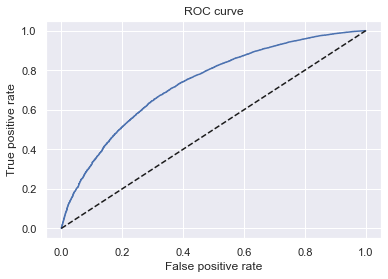

In [90]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [91]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.7327864794265222

In [92]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

0.4655729588530444

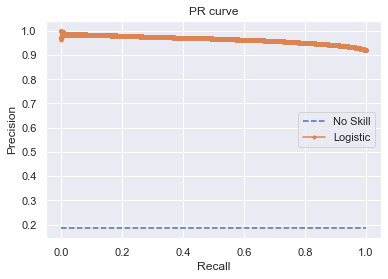

In [93]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [94]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.9642915974825608

# Scorecard Creation

In [95]:
df_scorecard = summary_table

In [96]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,Feature name,Coefficients,Original feature name
0,Intercept,0.000105,Intercept
1,CODE_GENDER:M,-0.185473,CODE_GENDER
2,CODE_GENDER:F_XNA,0.184035,CODE_GENDER
3,NAME_EDUCATION_TYPE:Academic degree,1.004184,NAME_EDUCATION_TYPE
4,NAME_EDUCATION_TYPE:Higher education,0.066009,NAME_EDUCATION_TYPE
...,...,...,...
70,EXT_SOURCE_3:0.448-0.538,0.087598,EXT_SOURCE_3
71,EXT_SOURCE_3:0.538-0.627,0.471833,EXT_SOURCE_3
72,EXT_SOURCE_3:0.627-0.717,0.661261,EXT_SOURCE_3
73,EXT_SOURCE_3:0.717-0.806,0.870317,EXT_SOURCE_3


In [97]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [98]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,Intercept,0.000105,Intercept,568.434450,568.0
1,CODE_GENDER:M,-0.185473,CODE_GENDER,-9.843953,-10.0
2,CODE_GENDER:F_XNA,0.184035,CODE_GENDER,9.767603,10.0
3,NAME_EDUCATION_TYPE:Academic degree,1.004184,NAME_EDUCATION_TYPE,53.296784,53.0
4,NAME_EDUCATION_TYPE:Higher education,0.066009,NAME_EDUCATION_TYPE,3.503398,4.0
...,...,...,...,...,...
70,EXT_SOURCE_3:0.448-0.538,0.087598,EXT_SOURCE_3,4.649263,5.0
71,EXT_SOURCE_3:0.538-0.627,0.471833,EXT_SOURCE_3,25.042395,25.0
72,EXT_SOURCE_3:0.627-0.717,0.661261,EXT_SOURCE_3,35.096243,35.0
73,EXT_SOURCE_3:0.717-0.806,0.870317,EXT_SOURCE_3,46.191840,46.0


In [99]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

299.0
850.0


In [100]:
pd.options.display.max_rows = 75
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard.sort_values(by = ['Score - Preliminary','Difference'])

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
65,EXT_SOURCE_3:<0.0901,-1.238073,EXT_SOURCE_3,-65.710369,-66.0,-0.289631
55,EXT_SOURCE_2:<0.0855,-0.975800,EXT_SOURCE_2,-51.790320,-52.0,-0.209680
66,EXT_SOURCE_3:0.0901-0.18,-0.903760,EXT_SOURCE_3,-47.966803,-48.0,-0.033197
15,NAME_INCOME_TYPE:student_unemployed,-0.909504,NAME_INCOME_TYPE,-48.271671,-48.0,0.271671
56,EXT_SOURCE_2:0.0855-0.171,-0.637806,EXT_SOURCE_2,-33.851370,-34.0,-0.148630
67,EXT_SOURCE_3:0.18-0.269,-0.605567,EXT_SOURCE_3,-32.140278,-32.0,0.140278
6,NAME_EDUCATION_TYPE:Lower secondary,-0.556825,NAME_EDUCATION_TYPE,-29.553322,-30.0,-0.446678
57,EXT_SOURCE_2:0.171-0.256,-0.446583,EXT_SOURCE_2,-23.702274,-24.0,-0.297726
7,NAME_EDUCATION_TYPE:Secondary / secondary special,-0.364279,NAME_EDUCATION_TYPE,-19.334006,-19.0,0.334006
68,EXT_SOURCE_3:0.269-0.359,-0.258693,EXT_SOURCE_3,-13.730079,-14.0,-0.269921


In [101]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[65, 'Score - Final'] = -65 # plus one on EXT_SOURCE_3:<0.0901
df_scorecard

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,Intercept,0.000105,Intercept,568.434450,568.0,-0.434450,568.0
1,CODE_GENDER:M,-0.185473,CODE_GENDER,-9.843953,-10.0,-0.156047,-10.0
2,CODE_GENDER:F_XNA,0.184035,CODE_GENDER,9.767603,10.0,0.232397,10.0
3,NAME_EDUCATION_TYPE:Academic degree,1.004184,NAME_EDUCATION_TYPE,53.296784,53.0,-0.296784,53.0
4,NAME_EDUCATION_TYPE:Higher education,0.066009,NAME_EDUCATION_TYPE,3.503398,4.0,0.496602,4.0
5,NAME_EDUCATION_TYPE:Incomplete higher,-0.150527,NAME_EDUCATION_TYPE,-7.989204,-8.0,-0.010796,-8.0
6,NAME_EDUCATION_TYPE:Lower secondary,-0.556825,NAME_EDUCATION_TYPE,-29.553322,-30.0,-0.446678,-30.0
7,NAME_EDUCATION_TYPE:Secondary / secondary special,-0.364279,NAME_EDUCATION_TYPE,-19.334006,-19.0,0.334006,-19.0
8,NAME_FAMILY_STATUS:Single_Unknown,-0.042824,NAME_FAMILY_STATUS,-2.272879,-2.0,0.272879,-2.0
9,NAME_FAMILY_STATUS:Civil marriage,-0.073699,NAME_FAMILY_STATUS,-3.911555,-4.0,-0.088445,-4.0


In [102]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

300.0
850.0


## Calculating credit scores for all observations in the test data set

In [103]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,CODE_GENDER:M,CODE_GENDER:F_XNA,NAME_EDUCATION_TYPE:Academic degree,NAME_EDUCATION_TYPE:Higher education,NAME_EDUCATION_TYPE:Incomplete higher,NAME_EDUCATION_TYPE:Lower secondary,NAME_EDUCATION_TYPE:Secondary / secondary special,NAME_FAMILY_STATUS:Single_Unknown,NAME_FAMILY_STATUS:Civil marriage,NAME_FAMILY_STATUS:Married,NAME_FAMILY_STATUS:Separated,NAME_FAMILY_STATUS:Widow,NAME_INCOME_TYPE:Business_comm,NAME_INCOME_TYPE:Pensioner_maternity,NAME_INCOME_TYPE:student_unemployed,NAME_INCOME_TYPE:State servant,NAME_INCOME_TYPE:Working,REG_CITY_NOT_LIVE_CITY:0,REG_CITY_NOT_LIVE_CITY:1,FLAG_DOCUMENT_3:0,FLAG_DOCUMENT_3:1,REGION_RATING_CLIENT_W_CITY:0,REGION_RATING_CLIENT_W_CITY:1,REGION_RATING_CLIENT_W_CITY:2,REGION_POPULATION_RELATIVE:<0.0147,REGION_POPULATION_RELATIVE:0.0147-0.0292,REGION_POPULATION_RELATIVE:0.0292-0.0436,REGION_POPULATION_RELATIVE:0.0436-0.0581,REGION_POPULATION_RELATIVE:>0.0581,YEAR_LAST_PHONE_CHANGE:<2,YEAR_LAST_PHONE_CHANGE:2-4,YEAR_LAST_PHONE_CHANGE:4-6,YEAR_LAST_PHONE_CHANGE:6-8,YEAR_LAST_PHONE_CHANGE:8-10,YEAR_LAST_PHONE_CHANGE:>10,AMT_CREDIT:<846000,AMT_CREDIT:846000-1647000,AMT_CREDIT:1647000-2448000,AMT_CREDIT:2448000-3249000,AMT_CREDIT:>3249000,YEAR_ID_PUBLISH:<4,YEAR_ID_PUBLISH:4-8,YEAR_ID_PUBLISH:8-12,YEAR_ID_PUBLISH:12-16,YEAR_ID_PUBLISH:>16,YEAR_REGISTRATION:<17,YEAR_REGISTRATION:17-34,YEAR_REGISTRATION:34-51,YEAR_REGISTRATION:>51,YEAR_BIRTH:<30,YEAR_BIRTH:30-40,YEAR_BIRTH:40-50,YEAR_BIRTH:50-60,YEAR_BIRTH:>60,EXT_SOURCE_2:<0.0855,EXT_SOURCE_2:0.0855-0.171,EXT_SOURCE_2:0.171-0.256,EXT_SOURCE_2:0.256-0.342,EXT_SOURCE_2:0.342-0.427,EXT_SOURCE_2:0.427-0.513,EXT_SOURCE_2:0.513-0.598,EXT_SOURCE_2:0.598-0.684,EXT_SOURCE_2:0.684-0.769,EXT_SOURCE_2:>0.769,EXT_SOURCE_3:<0.0901,EXT_SOURCE_3:0.0901-0.18,EXT_SOURCE_3:0.18-0.269,EXT_SOURCE_3:0.269-0.359,EXT_SOURCE_3:0.359-0.448,EXT_SOURCE_3:0.448-0.538,EXT_SOURCE_3:0.538-0.627,EXT_SOURCE_3:0.627-0.717,EXT_SOURCE_3:0.717-0.806,EXT_SOURCE_3:>0.806
128081,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
68695,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
280602,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
93006,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
125876,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [104]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final'].to_frame().to_numpy()
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(61503, 75)
(75, 1)


In [105]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

,0
128081,609.0
68695,553.0
280602,592.0
93006,550.0
125876,556.0


## Setting loan approval cut-offs

In [106]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.299883


Best Threshold: 0.299883

This means that based on the Youden's J statistic, the ideal probability threshold is 0.299883 which minimizes the FPR and maximimizes the TPR - all samples with a predicted probability higher than this should be classified as in Default and vice versa.

We can confirm this by looking at our original confusion matrix with the updated threshold

In [107]:
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
print(classification_report(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted']))

              precision    recall  f1-score   support

           0       0.15      0.67      0.25      4965
           1       0.96      0.68      0.80     56538

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503



In [108]:
tr = best_thresh
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
print(classification_report(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted']))

              precision    recall  f1-score   support

           0       0.25      0.30      0.28      4965
           1       0.94      0.92      0.93     56538

    accuracy                           0.87     61503
   macro avg       0.59      0.61      0.60     61503
weighted avg       0.88      0.87      0.88     61503



In [109]:
# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs.head()

,thresholds,Score
0,0.037358,396.0
1,0.038495,398.0
2,0.040318,400.0
3,0.041021,401.0
4,0.043889,405.0


In [110]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [111]:
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs.head()

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,0.037358,396.0,61503,0,1.000000,0.000000
1,0.038495,398.0,61502,1,0.999984,0.000016
2,0.040318,400.0,61501,2,0.999967,0.000033
3,0.041021,401.0,61500,3,0.999951,0.000049
4,0.043889,405.0,61499,4,0.999935,0.000065


In [112]:
best_thresh

0.2998829124632645

In [113]:
# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.299880, 0.299883)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
5727,0.299883,523.0,55517,5986,0.902671,0.097329


Accordingly, we will stick with our ideal threshold and the corresponding Credit Score of 523, and will monitor the model's performance in production

In [114]:
df_scorecard['specific feature'] = df_scorecard['Feature name'].apply(lambda x: x.split(":")[1] if x != 'Intercept' else 'Intercept')

In [115]:
df_scorecard[['Original feature name', 'specific feature', 'Score - Final']]

,Original feature name,specific feature,Score - Final
0,Intercept,Intercept,568.0
1,CODE_GENDER,M,-10.0
2,CODE_GENDER,F_XNA,10.0
3,NAME_EDUCATION_TYPE,Academic degree,53.0
4,NAME_EDUCATION_TYPE,Higher education,4.0
5,NAME_EDUCATION_TYPE,Incomplete higher,-8.0
6,NAME_EDUCATION_TYPE,Lower secondary,-30.0
7,NAME_EDUCATION_TYPE,Secondary / secondary special,-19.0
8,NAME_FAMILY_STATUS,Single_Unknown,-2.0
9,NAME_FAMILY_STATUS,Civil marriage,-4.0
